## Import libraries

### Run on colab

In [1]:
%cd /content
!git clone https://github.com/Giovannicus/GreenTech-AI.git
%cd GreenTech-AI
!git checkout main

/content
fatal: destination path 'GreenTech-AI' already exists and is not an empty directory.
/content/GreenTech-AI
Already on 'main'
Your branch is up to date with 'origin/main'.


### install libraries

In [ ]:
!pip install -r requirements.txt

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import os
import torch.optim as optim
import torchvision
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from src import *
from torchinfo import summary
import logging
import time
from torch.utils.data import Subset
import timm

c:\Users\gcusumano\ProfAI\GreenTech-AI\.venv\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Data preprocessing

### extract images zip

In [ ]:
# avoid time consuming importing dataset on colab, unzipping is faster
download_and_extract("https://proai-datasets.s3.eu-west-3.amazonaws.com/progetto-finale-flowes.tar.gz")

### transform and get dataloaders

In [5]:
# transform images to get some augmentation
class Transforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

transform = A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(),
        A.Rotate(limit=10),
        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ToTensorV2(),
      ])

transform2 = A.Compose([
        A.Resize(224, 224),
        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ToTensorV2(),
      ])

In [6]:
trainset = torchvision.datasets.ImageFolder(root='dataset/train', transform=Transforms(transform))
valset = torchvision.datasets.ImageFolder(root='dataset/valid', transform=Transforms(transform2))
testset = torchvision.datasets.ImageFolder(root='dataset/test',transform=Transforms(transform2))

In [7]:
len(trainset), len(valset), len(testset)

(1275, 364, 182)

In [8]:
def fix_path(path_tuple):
    path, label = path_tuple
    fixed_path = path.replace('\\', '/')
    return (fixed_path, label)

In [9]:
trainset.imgs = [fix_path(item) for item in trainset.imgs]
valset.imgs = [fix_path(item) for item in valset.imgs]
testset.imgs = [fix_path(item) for item in testset.imgs]

In [ ]:
batch_size=32

# stratified kfold to avoid unbalanced dataset
train_indices = get_balanced_indices(trainset, len(trainset))
val_indices = get_balanced_indices(valset, len(valset))
test_indices = get_balanced_indices(testset, len(testset))

balanced_trainset = Subset(trainset, train_indices)
balanced_valset = Subset(valset, val_indices)
balanced_testset = Subset(testset, test_indices)

trainloader = torch.utils.data.DataLoader(balanced_trainset,batch_size=batch_size,shuffle=True)
valloader = torch.utils.data.DataLoader(balanced_valset,batch_size=batch_size,shuffle=False)
testloader = torch.utils.data.DataLoader(balanced_testset,batch_size=batch_size,shuffle=False)


### check distribution

In [11]:
label_counts = torch.zeros(len(trainset.classes))
for _, labels in trainloader.dataset.dataset.imgs:
    label_counts[labels] += 1

In [12]:
# interactive pieplot
fig = plot_class_distribution(
    label_counts,
    class_names=trainset.classes,
    title="Dataset Distribution",
    paper_bgcolor="rgba(255255,255,.1)",
    plot_bgcolor="rgba(0,0,0,0)",
    t=10,b=10,l=10,r=100,
    height=600,width=600,
    legend_x_anchor="center",
    legend_y_anchor="middle",
    legend_orientation = "v",
    legend_x = -.3,
    legend_y = 1
)
fig.show()

## Transfer Learning

i chose model according to accuracy, number of trainable parameters and image size input

In [52]:
device="cuda" if torch.cuda.is_available() else "cpu"
model = timm.create_model('resnet18.a1_in1k',pretrained=True, num_classes=2).to(device)
summary(model, input_size=(1, 3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─Identity: 3-3                [1, 64, 56, 56]           --
│    │    └─ReLU: 3-4                    [1, 64, 56, 56]           --
│    │    └─Identity: 3-5                [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-6                  [1, 64, 56, 56]           36,864
│ 

## Training

### set train test

In [14]:
def train(net, dataloader, criterion, optimizer,device):
    """ trains an epoch and returns metrics"""
    net.train()
    n_batches = len(dataloader)
    total_loss = 0
    total_f1 = 0
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        output = net(inputs)

        net.zero_grad()

        loss = criterion(output, targets)

        loss.backward()
        optimizer.step()

        _, preds = torch.max(output.data, 1)
        f1 = get_f1(preds, targets)

        total_loss += loss.item()
        total_f1 += f1

    mean_loss = total_loss / n_batches
    mean_f1 = total_f1 / n_batches
    return mean_loss, mean_f1

def test(net, test_loader, criterion,device):

    net.eval()
    test_loss = 0
    test_f1 = 0
    n_batches = len(test_loader)

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)

            output = net(data)
            test_loss += criterion(output, target).item()

            _, preds = torch.max(output.data, 1)
            batch_f1 = get_f1(preds, target)
            test_f1 += batch_f1

    test_loss /= n_batches
    test_f1 /= n_batches

    print(f"\nFinal validation metrics:")
    print(f"Loss: {test_loss:.4f}")
    print(f"F1_score: {test_f1:.4f}")

    return test_loss, test_f1

def get_predictions(model_output):
    val, idx = torch.max(model_output, dim=1)
    return idx

def get_f1(preds: torch.Tensor, targets: torch.Tensor, threshold: float = 0.5) -> float:
    """ returns mean f1_scores ignoring nan or non-involved classes"""
    device = targets.device
    preds = preds.to(device)

    preds = manual_one_hot(preds,2)
    targets = manual_one_hot(targets,2)
    f1s = []
    num_classes = preds.shape[1]
    for class_idx in range(num_classes):

        class_preds = preds[:, class_idx]
        class_targets = targets[:, class_idx]

        true_positives = (class_preds * class_targets).sum()
        false_positives = (class_preds * (1 - class_targets)).sum()
        false_negatives = ((1 - class_preds) * class_targets).sum()
        total_predicted_p = true_positives+false_positives
        total_predicted_a = true_positives+false_negatives

        if (total_predicted_a > 0) & (total_predicted_p > 0):
            precision = true_positives / total_predicted_p
            accuracy = true_positives/total_predicted_a
            class_f1 = 2*accuracy*precision/(precision+accuracy)
        else:
            class_f1 = torch.nan
        f1s.append(class_f1)

    f1_tensor = torch.tensor(f1s)
    mean_f1 = f1_tensor.nanmean().item()

    return mean_f1


def adjust_learning_rate(lr, decay, optimizer, cur_epoch, n_epochs):
    """Sets the learning rate to the initially
        configured `lr` decayed by `decay` every `n_epochs`"""
    new_lr = lr * (decay ** (cur_epoch // n_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_uniform(m.weight)
        m.bias.data.zero_()

def save_weights(model, weights_dir, epoch):
    weights_fname = 'weights-%d.pth' % (epoch)
    weights_fpath = os.path.join(weights_dir, weights_fname)
    torch.save({'state_dict': model.state_dict()}, weights_fpath)

def load_weights(model, fpath):
    state = torch.load(fpath)
    model.load_state_dict(state['state_dict'])

def manual_one_hot(tensor, num_classes=None):
    tensor = tensor.to(dtype=torch.long)

    if num_classes is None:
        num_classes = tensor.max() + 1

    one_hot = torch.zeros((tensor.size(0), num_classes), device=tensor.device)
    one_hot.scatter_(1, tensor.unsqueeze(1), 1)

    return one_hot

### run before starting exps

In [ ]:
xps = []
#shutil.rmtree("exps") #run to clear exps

### new experiment

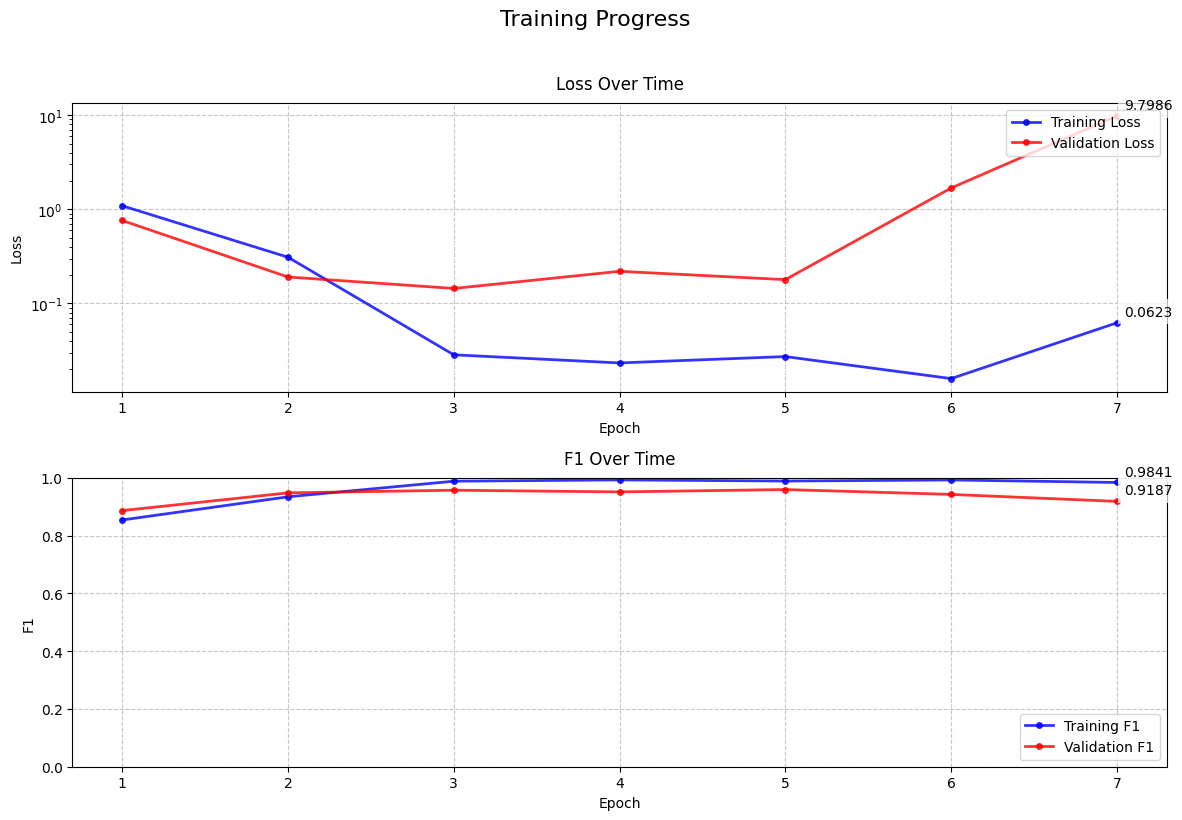

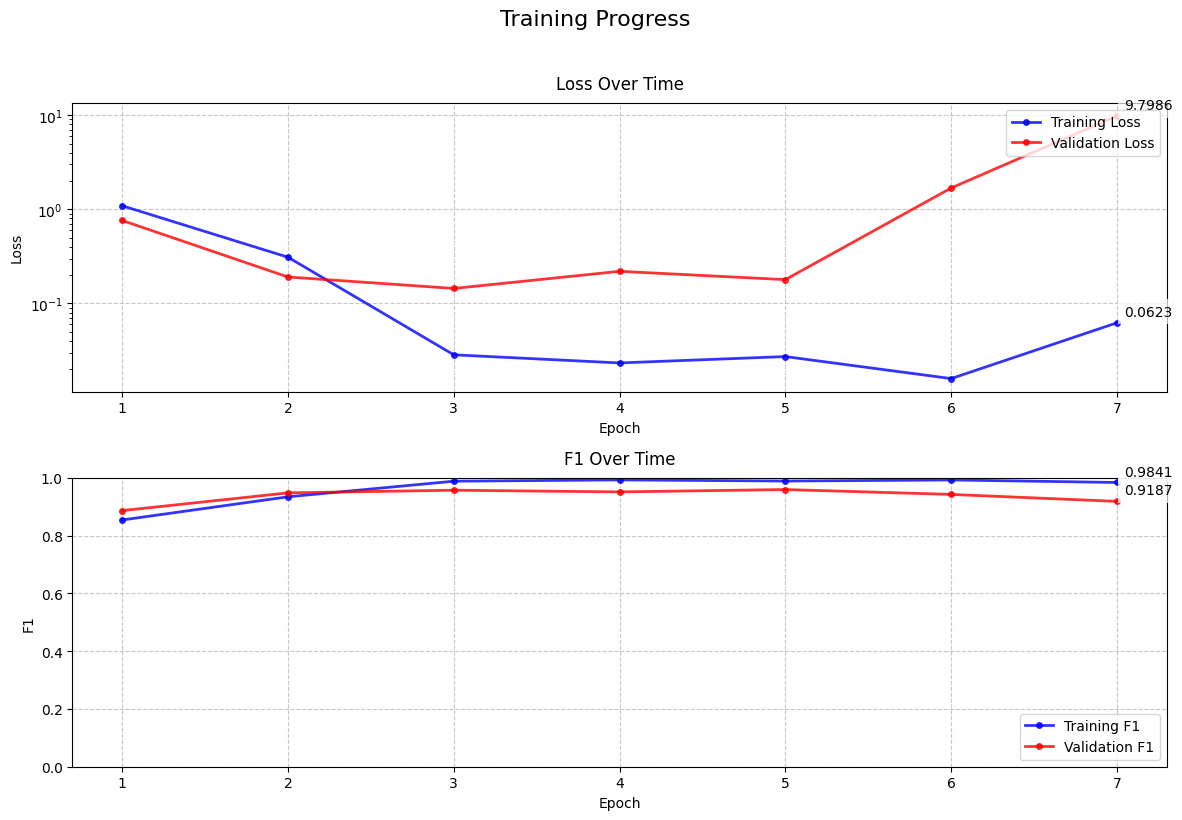

Early Stopping at epoch 7 since no better loss found since epoch 3


<Figure size 640x480 with 0 Axes>

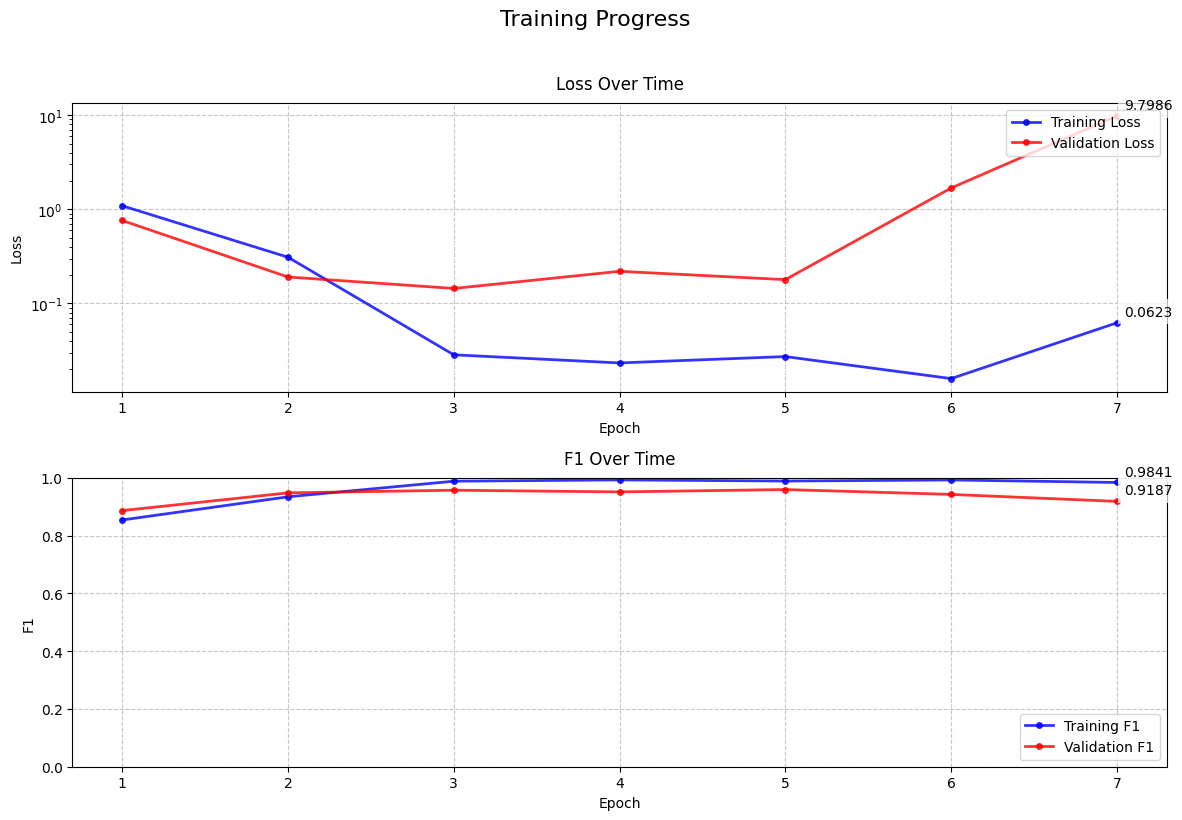

In [ ]:
N_EPOCHS = 15
MAX_PATIENCE = 3
LEARNING_RATE = 1e-3
LR_DECAY = 0.99
DECAY_LR_EVERY_N_EPOCHS = 2
EXPERIMENT_NAME = 'exp_effnet'

#model = timm.create_model('resnet18.a1_in1k',pretrained=True, num_classes=2).to(device)
model = timm.create_model('efficientnet_b3.ra2_in1k',pretrained=True, num_classes=2).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
logger = get_logger(ch_log_level=logging.INFO, fh_log_level=logging.INFO)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print('  + Number of params: {}'.format(sum([p.data.nelement() for p in model.parameters()])))
exp = Experiment(EXPERIMENT_NAME, "exps", logger)
#shutil.rmtree("exps/exp1")
exp.init()
monitor = TrainingMonitor()

for epoch in range(exp.epoch, exp.epoch+N_EPOCHS):
    since = time.time()

    trn_loss, trn_f1 = train(model, trainloader, criterion, optimizer,device)
    logger.info('Epoch {:d}: Train - Loss: {:.4f}\tF1_score: {:.4f}'.format(
        epoch, trn_loss, trn_f1))
    time_elapsed = time.time() - since
    logger.info('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    val_loss, val_f1 = test(model, valloader, criterion,device)
    logger.info('Val - Loss: {:.4f}, F1_score: {:.4f}'.format(
        val_loss, val_f1))
    time_elapsed = time.time() - since
    logger.info('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))

    monitor.update(
        epoch=epoch,
        train_loss=trn_loss,
        val_loss=val_loss,
        train_f1=trn_f1,
        val_f1=val_f1
    )

    exp.save_history('train', trn_loss, trn_f1)
    exp.save_history('val', val_loss, val_f1)

    exp.save_weights(model, trn_loss, val_loss, trn_f1, val_f1)
    exp.save_optimizer(optimizer, val_loss)

    if (epoch - exp.best_val_loss_epoch) > MAX_PATIENCE:
        logger.info(f"Early Stopping at epoch {epoch} since no better loss found since epoch {exp.best_val_loss_epoch}")
        break

    adjust_learning_rate(LEARNING_RATE, LR_DECAY, optimizer,
                         epoch, DECAY_LR_EVERY_N_EPOCHS)

    exp.epoch += 1

try:
    monitor.save(os.path.join(exp.history_dir, 'final_training_progress.png'))
    monitor.stop()
except:
    pass

xps.append((EXPERIMENT_NAME, np.max(exp.f1_history["val"])))

### run if already have exps and avoid training

In [ ]:
import zipfile
with zipfile.ZipFile("exp_resnet.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
with zipfile.ZipFile("exp_effnet.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

### check best model

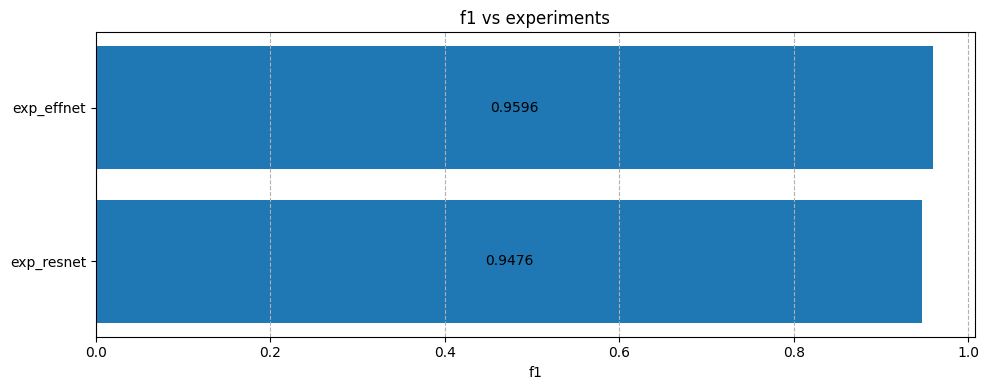

In [ ]:
xps.sort(key=lambda x: x[1], reverse=False)
folder_names, f1 = zip(*xps)

plt.figure(figsize=(10, 4))
bars = plt.barh(folder_names, f1)
plt.grid(axis='x', linestyle='--')

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2,
             f'{f1[i]:.4f}',
             ha='center', va='center')

plt.title('f1 vs experiments')
plt.xlabel('f1')
plt.tight_layout()
plt.show()

### plot training history

In [67]:
fig = plot_training_history('exps/exp_resnet')
fig

## Final test

### pick best experiment

In [72]:
experiment = Experiment(name=max(dict(xps).items(), key=lambda x: x[1])[0], root="exps")

# load model best hyperparams
model, optimizer = experiment.resume(
    model=model,
    optim=optimizer,
    weights_fpath=experiment.best_weights_path,
    optim_path=experiment.best_optimizer_path
)

/content/GreenTech-AI/src/logexp/logexp.py:158: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/content/GreenTech-AI/src/logexp/logexp.py:179: FutureWarning:

You are using `

### set final test and confusion matrix

In [82]:
def get_confusion_matrix(preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """
    Calculate confusion matrix given predictions and targets.

    Args:
        preds: torch.Tensor - Model predictions (already processed with argmax if necessary)
        targets: torch.Tensor - Ground truth targets

    Returns:
        confusion_matrix: torch.Tensor - Confusion matrix of shape (num_classes x num_classes)
    """
    confusion_matrix = torch.zeros(2, 2)
    for t, p in zip(targets.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1
    return confusion_matrix

def calculate_metrics(confusion_matrix: torch.Tensor) -> dict:
    """
    Calculate various metrics from the confusion matrix using only PyTorch operations.

    Args:
        confusion_matrix: torch.Tensor - Confusion matrix of shape (num_classes x num_classes)

    Returns:
        dict: Dictionary containing various metrics
    """
    # Per-class metrics
    class_precision = confusion_matrix.diag() / confusion_matrix.sum(dim=1).clamp(min=1e-10)
    class_recall = confusion_matrix.diag() / confusion_matrix.sum(dim=0).clamp(min=1e-10)

    # Calculate F1 score
    class_f1 = 2 * (class_precision * class_recall) / (class_precision + class_recall + 1e-10)

    # Calculate macro averages
    metrics = {
        'macro_precision': float(torch.mean(class_precision)),
        'macro_recall': float(torch.mean(class_recall)),
        'macro_f1': float(torch.mean(class_f1)),
        'accuracy': float(confusion_matrix.diag().sum() / confusion_matrix.sum())
    }

    return metrics

def final_test(net, test_loader, criterion):
    """
    Perform final evaluation of the model on test data.

    Args:
        net: torch.nn.Module - The neural network model
        test_loader: torch.utils.data.DataLoader - Test data loader
        criterion: torch.nn.Module - Loss function

    Returns:
        tuple: (confusion_matrix, metrics_dict)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.eval()
    test_loss = 0
    n_batches = len(test_loader)

    # Initialize tensors for all predictions and targets
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)

            output = net(data)
            test_loss += criterion(output, target).item()

            _, preds = torch.max(output.data, 1)

            # Store predictions and targets
            all_preds.append(preds.cpu())
            all_targets.append(target.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    # Calculate final metrics
    test_loss /= n_batches
    confusion_matrix = get_confusion_matrix(all_preds, all_targets)
    metrics = calculate_metrics(confusion_matrix)

    # Print results
    print(f"\nFinal validation metrics:")
    print(f"Loss: {test_loss:.4f}")
    print("\nMetrics from confusion matrix:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

    return confusion_matrix, metrics


### visualize confusion matrix

In [83]:
confusion_matrix, metrics = final_test(model, testloader, criterion)
class_names = trainset.classes
plot_confusion_matrix(confusion_matrix,class_names)


Final validation metrics:
Loss: 0.4632

Metrics from confusion matrix:
macro_precision: 0.9281
macro_recall: 0.9281
macro_f1: 0.9281
accuracy: 0.9286
